## Regression Analysis_State-wise_Washington

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data = data[data.WA == 1]
data = data[features]
data

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
46,8.52,4.33,7.91,0.000000,35.627753,5.260000,904.797357,71298,7054655,0,0,0,1,4271.0,2341,2603
96,8.61,4.61,8.02,0.000000,30.476682,7.217241,962.256757,71298,7063739,0,0,0,1,3934.0,2179,2523
146,8.64,4.29,8.12,0.000000,40.075546,6.865625,768.013100,71298,7072822,1,0,0,0,3598.0,2315,2510
196,8.69,4.22,8.11,0.120000,45.580531,7.096875,580.235556,71298,7081906,1,0,0,0,2896.0,2302,2314
246,8.89,4.03,7.97,6.665198,53.736123,6.345161,353.982379,71298,7090989,1,0,0,0,2466.0,2388,2213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,10.06,5.42,8.70,89.805430,65.174661,6.210000,84.547511,71298,7667990,4,1,0,0,2470.0,2142,2454
3446,9.86,4.79,8.95,18.940639,56.161644,6.012903,282.388128,71298,7675576,3,0,1,0,2197.0,1965,2329
3496,9.67,4.93,8.80,0.000000,42.875909,5.786667,679.627273,71298,7683161,2,0,1,0,2850.0,1936,2377
3546,9.54,4.87,8.75,0.000000,38.806881,4.763333,778.564220,71298,7690746,1,0,1,0,3042.0,1878,2275


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data, commercial_numeric_columns)

Commercial_Retail Price        6.849942
CLDD                           5.043081
TAVG                         264.427640
AWND                           1.274277
HTDD                         230.474229
area                       10309.172722
population                     8.577639
solar-generation               4.424532
dtype: float64

In [9]:
cal_vif(data, residential_numeric_columns)

Residential_Retail Price        5.554614
CLDD                            5.035217
TAVG                          254.541202
AWND                            1.404353
HTDD                          226.138506
area                        11573.365033
population                      8.583747
solar-generation                4.984945
dtype: float64

In [10]:
cal_vif(data, industrial_numeric_columns)

Industrial_Retail Price        3.014607
CLDD                           7.286288
TAVG                         319.437221
AWND                           1.408602
HTDD                         274.895505
area                       11265.997181
population                     4.262276
solar-generation               4.447686
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, commercial_numeric_columns_adj)

const                      3731.299307
Commercial_Retail Price       6.591829
CLDD                          2.169356
AWND                          1.216786
HTDD                          3.994829
population                    8.168222
solar-generation              4.393280
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, industrial_numeric_columns_adj)

const                      3622.501673
Industrial_Retail Price       2.401437
CLDD                          2.464148
AWND                          1.259901
HTDD                          3.989531
population                    3.783191
solar-generation              4.442072
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, residential_numeric_columns_adj)

const                       4904.977655
Residential_Retail Price       5.552924
CLDD                           2.151853
AWND                           1.346548
HTDD                           5.713858
population                     8.534801
solar-generation               4.952352
dtype: float64

In [14]:
data= data.drop(['TAVG', 'area'],axis = 1)

## Train Test Split and Data Scaling

In [15]:
#Train-Test Split
train, test = train_test_split(data, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [16]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'solar-generation', 'Summer', 'Fall', 'Winter', 'Residential_Usage',
       'Industrial_Usage', 'Commercial_Usage'],
      dtype='object')

In [17]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [18]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

### Commercial Consumption Forecast

In [19]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [20]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     10.78
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           7.42e-09
Time:                        15:38:30   Log-Likelihood:                -325.38
No. Observations:                  57   AIC:                             670.8
Df Residuals:                      47   BIC:                             691.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [21]:
df_pred_c

,Actual,Predicted
2046,2386,2372.848127
2546,2468,2425.744368
646,2552,2586.346179
2896,2353,2381.655012
1896,2463,2567.025804
2146,2514,2473.367937
1146,2343,2388.727856
146,2510,2379.230200
3096,2493,2625.751491
1046,2411,2304.438210


In [22]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [23]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 66.366667265509
Mean Squared Error: 5850.257940881382
Root Mean Squared Error: 76.48697889759656


## Commercial_Feature Importance

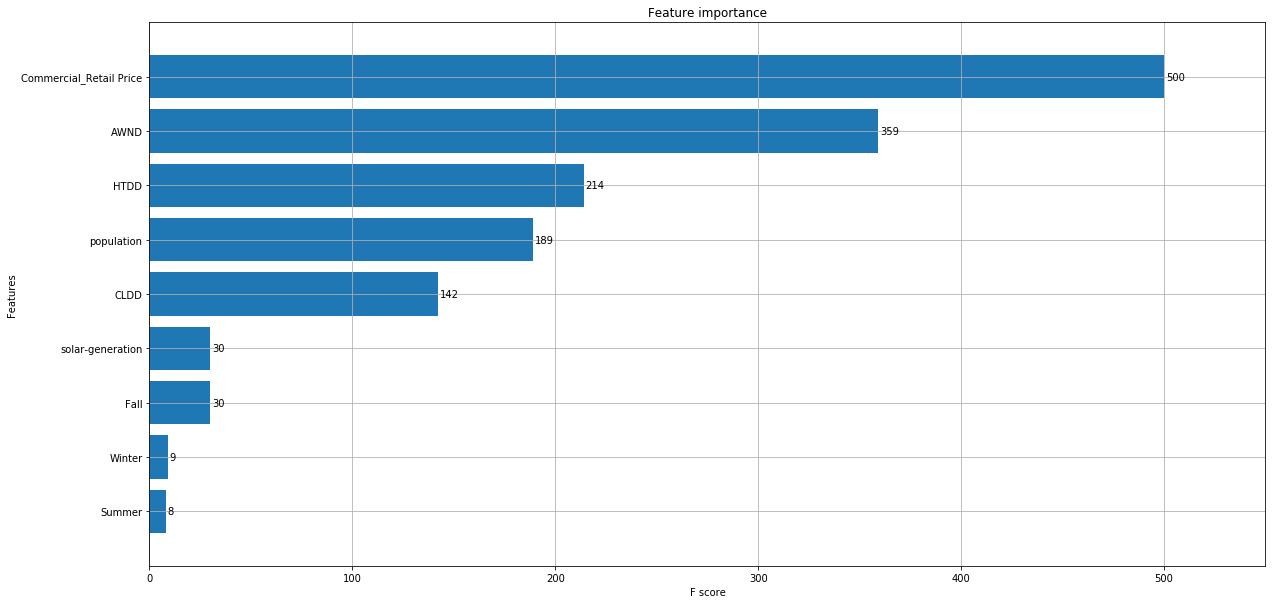

In [24]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

## Visualizations

In [25]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [26]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [27]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


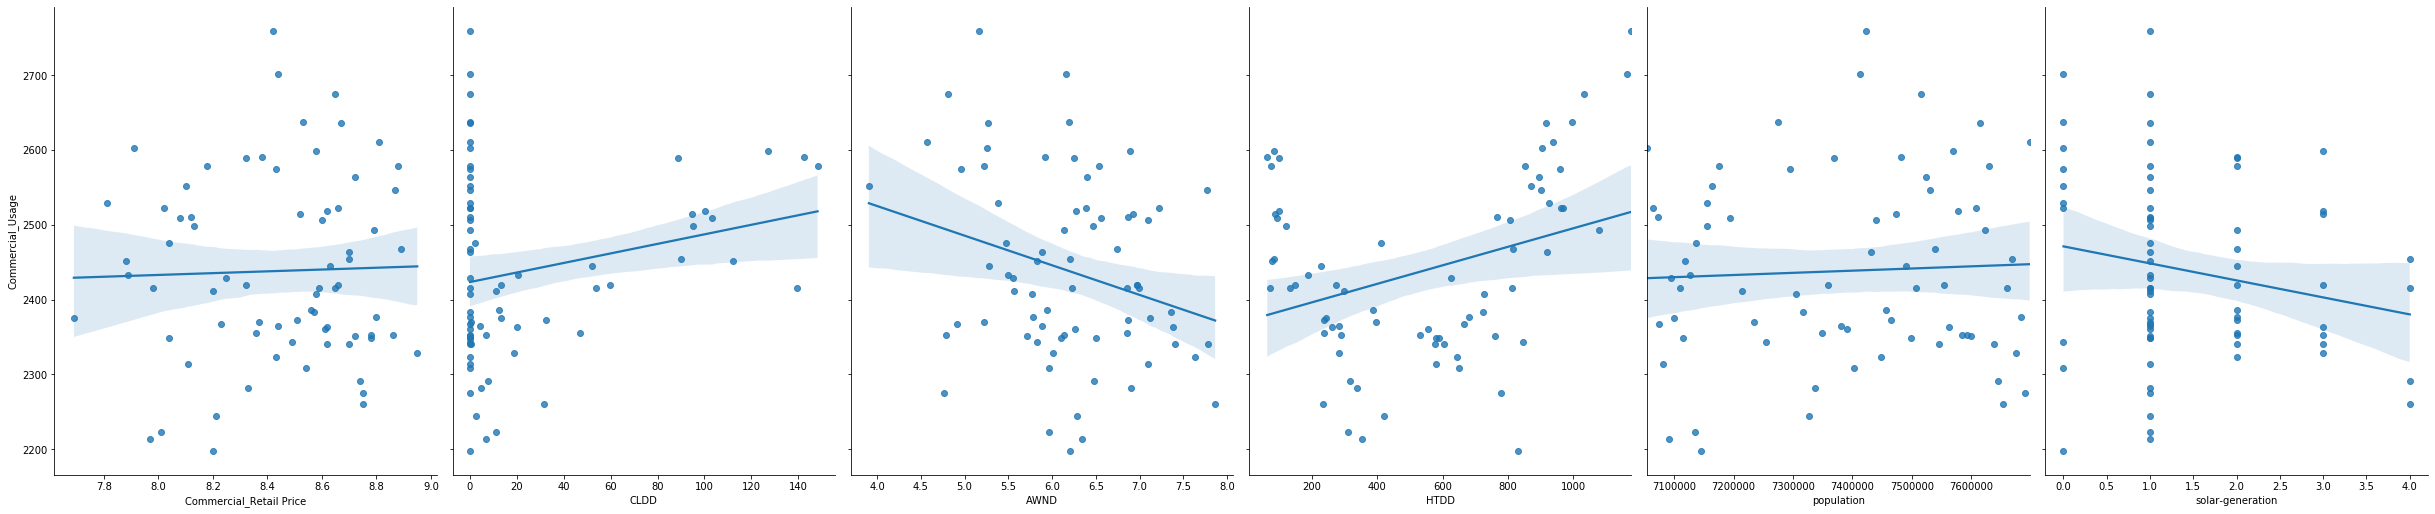

In [28]:
# Correlation Analysis
correlation_analysis(data, commercial_numeric_columns_adj, ['Commercial_Usage'])

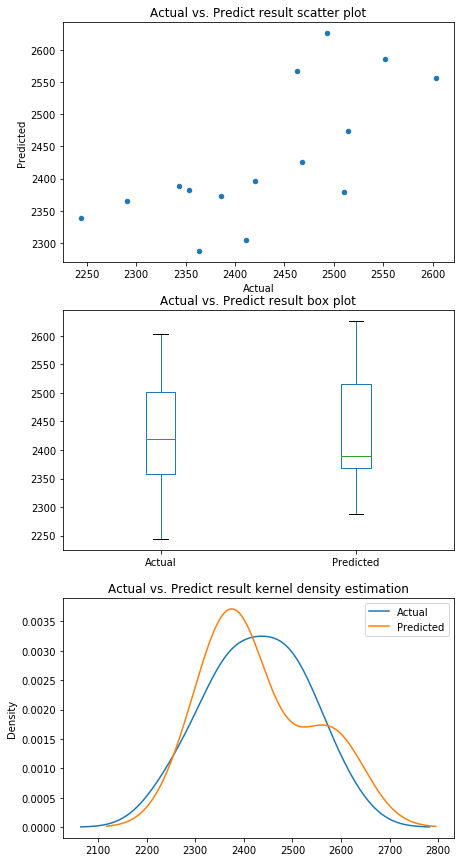

In [29]:
# Visualize Output
visualize_graph(df_pred_c)

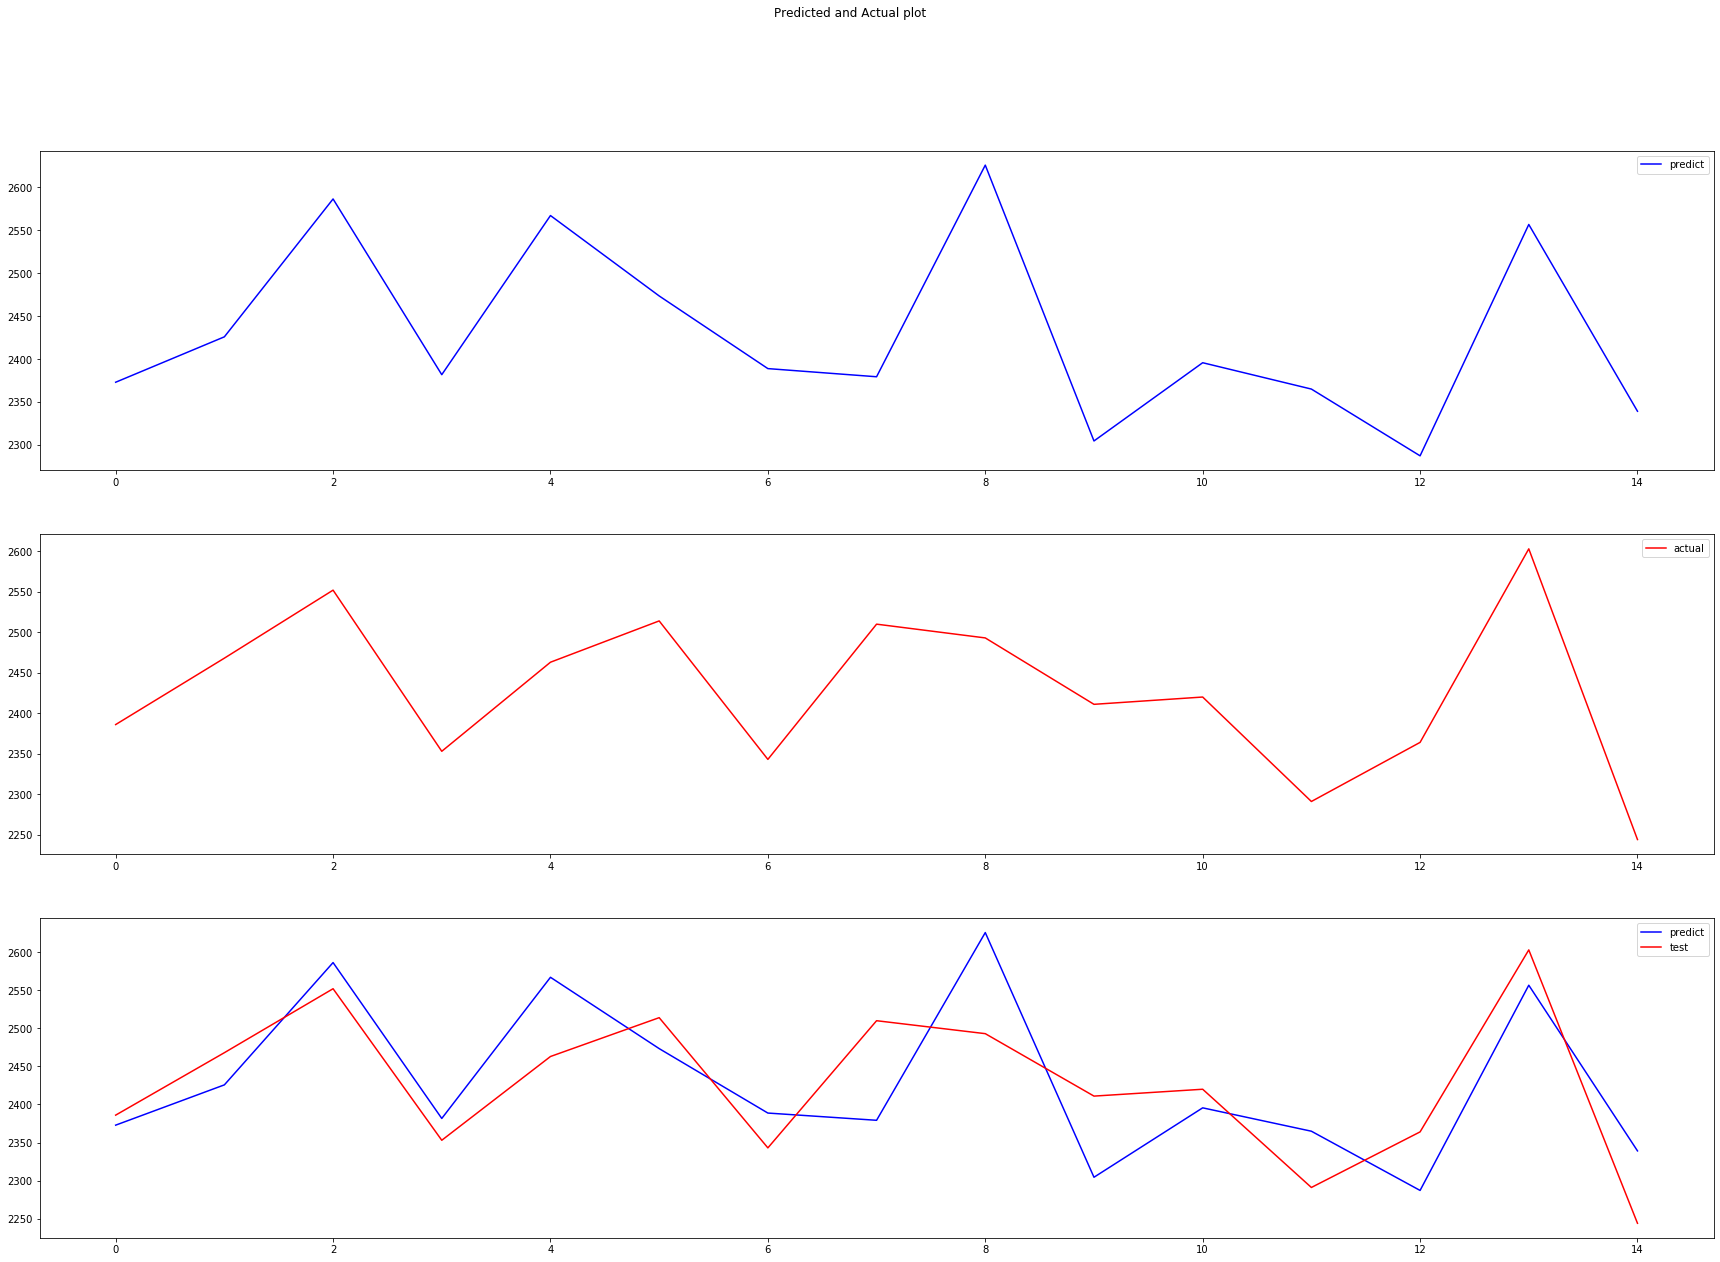

In [30]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

## Industrial Consumption Forecast

In [31]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     17.83
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           2.22e-12
Time:                        15:38:34   Log-Likelihood:                -319.43
No. Observations:                  57   AIC:                             658.9
Df Residuals:                      47   BIC:                             679.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [32]:
df_pred_i

,Actual,Predicted
2046,2018,2130.031180
2546,2092,2054.671798
646,2360,2279.781822
2896,2164,2057.839587
1896,1975,2085.658375
2146,2229,2220.553603
1146,2097,2155.332994
146,2315,2267.408818
3096,1837,1962.153047
1046,2210,2218.095614


In [33]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 64.73563256207665
Mean Squared Error: 5678.970929892141
Root Mean Squared Error: 75.35894724511576


# Industrial Feature Importance

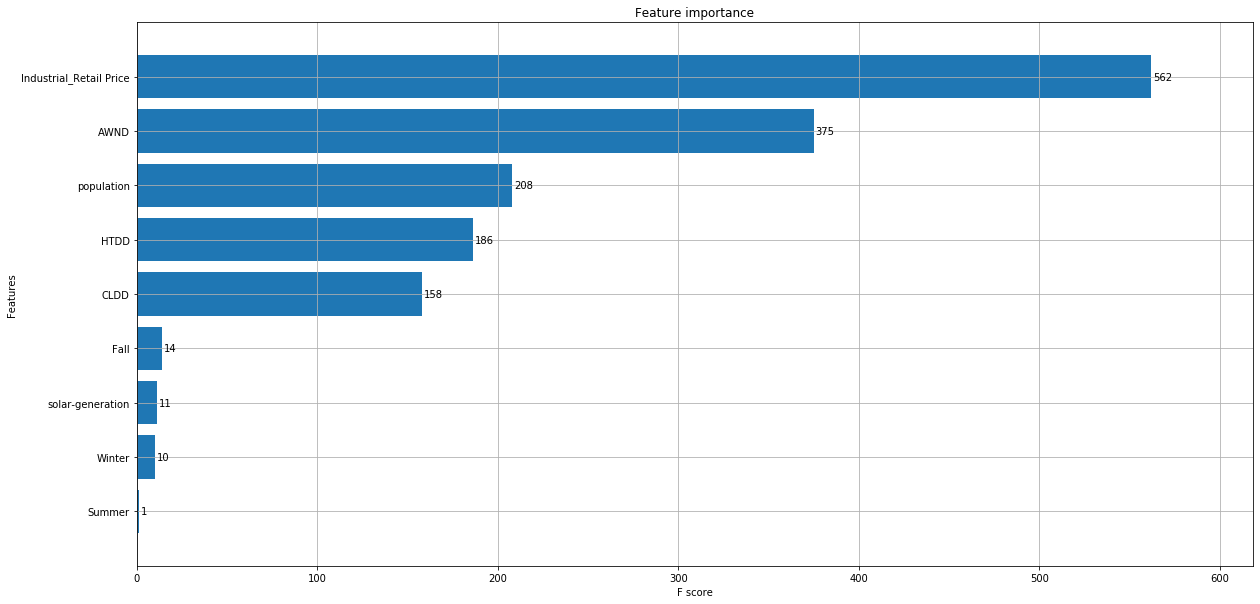

In [34]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


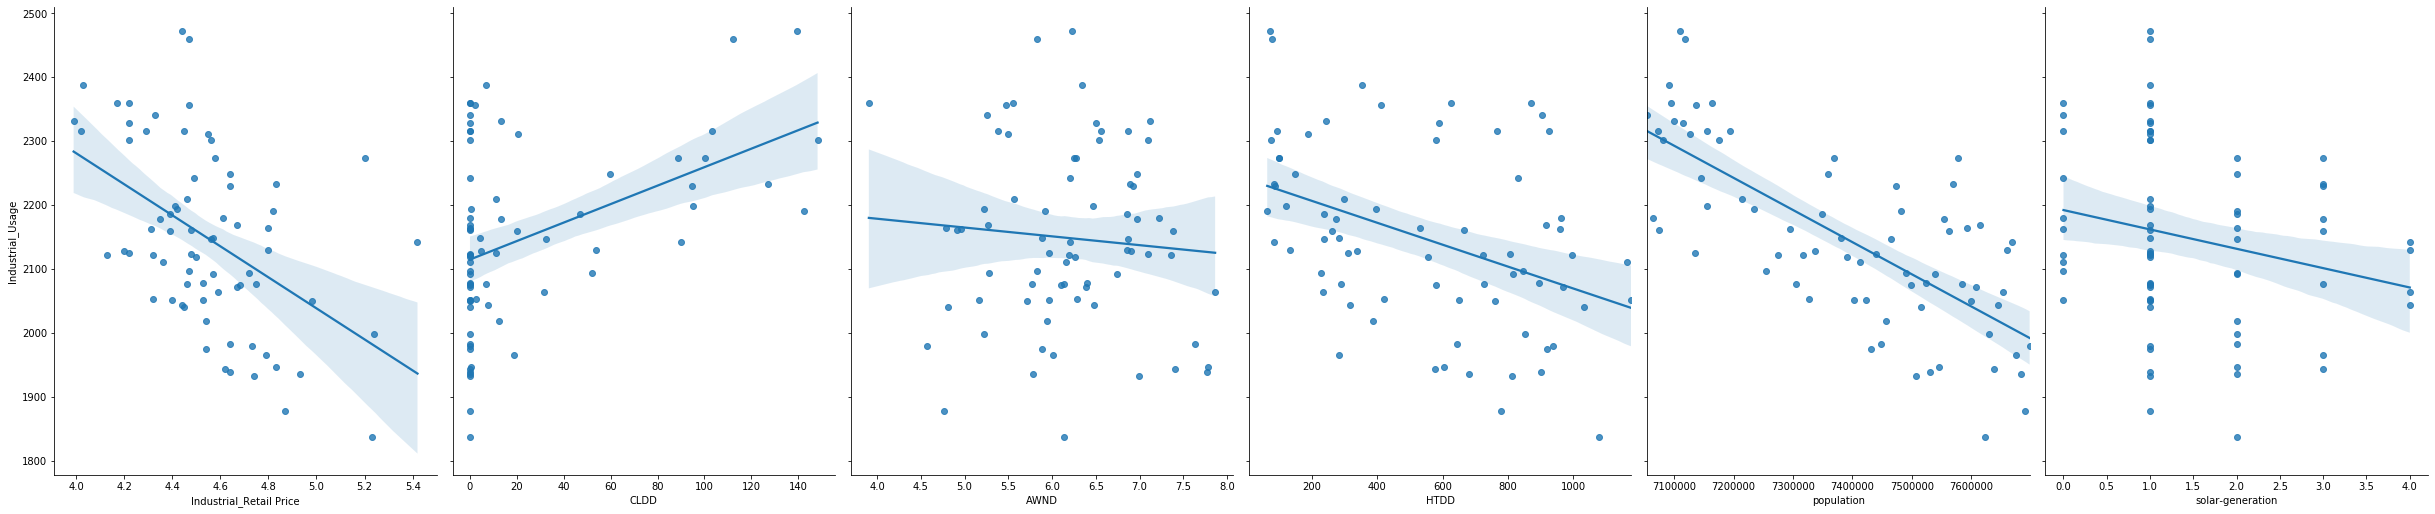

In [35]:
# Correlation Analysis
correlation_analysis(data, industrial_numeric_columns_adj, ['Industrial_Usage'])

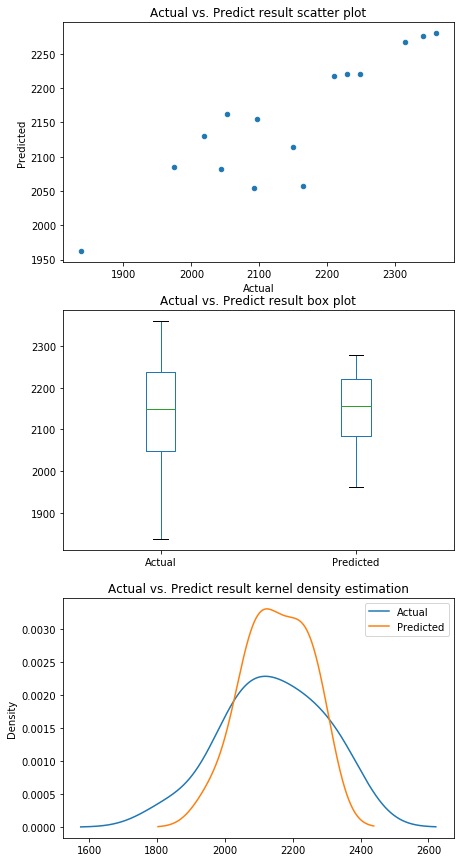

In [36]:
visualize_graph(df_pred_i)

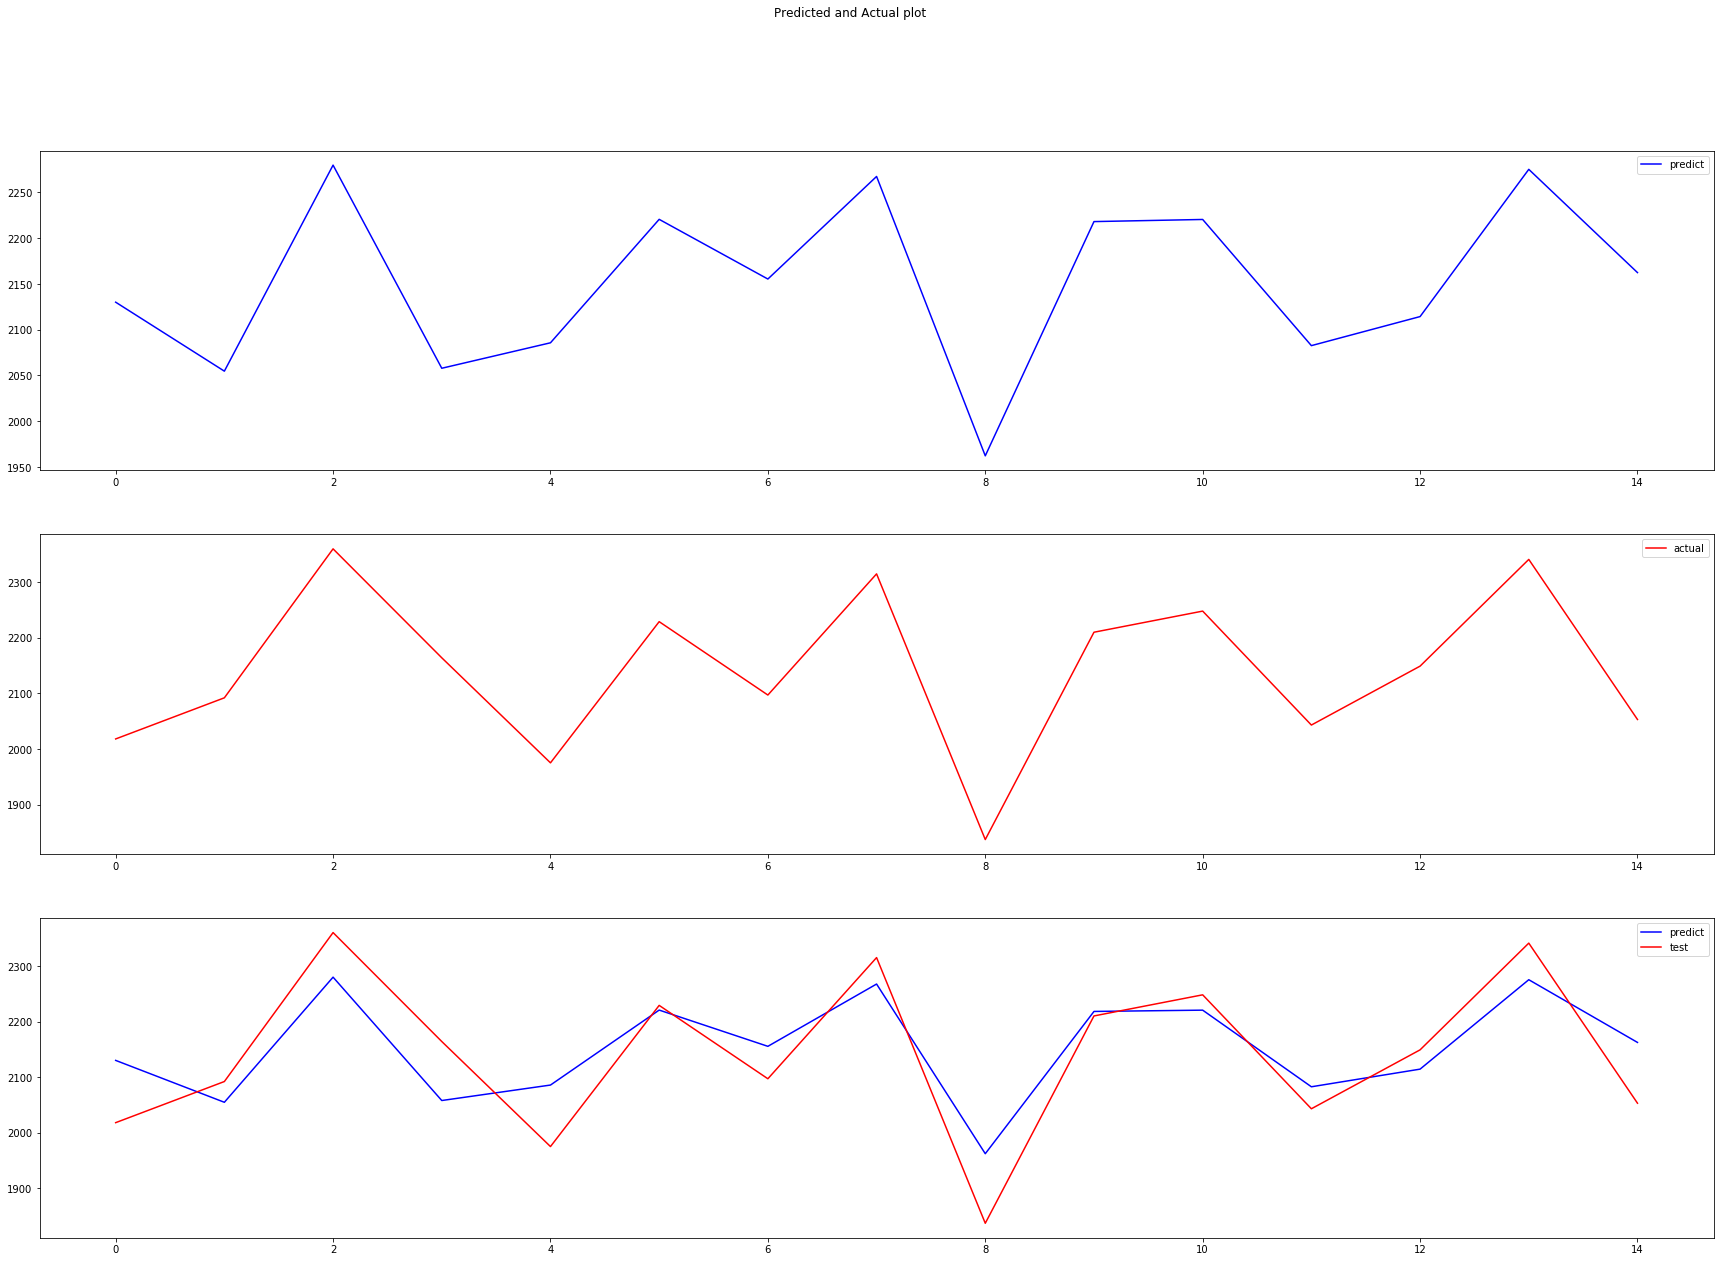

In [37]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

## Residential Consumption Forecast

In [38]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           4.23e-30
Time:                        15:38:37   Log-Likelihood:                -359.08
No. Observations:                  57   AIC:                             738.2
Df Residuals:                      47   BIC:                             758.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [39]:
df_pred_r

,Actual,Predicted
2046,2523.0,2681.765714
2546,3570.0,3484.906455
646,3863.0,3847.372267
2896,2535.0,2693.996115
1896,3766.0,3851.287971
2146,2555.0,2389.579541
1146,2936.0,3180.289240
146,3598.0,3248.857267
3096,3899.0,4224.676950
1046,2288.0,2105.997019


In [40]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 187.06400464384205
Mean Squared Error: 48214.10722356022
Root Mean Squared Error: 219.5771099717824


## Residential_Feature Importance

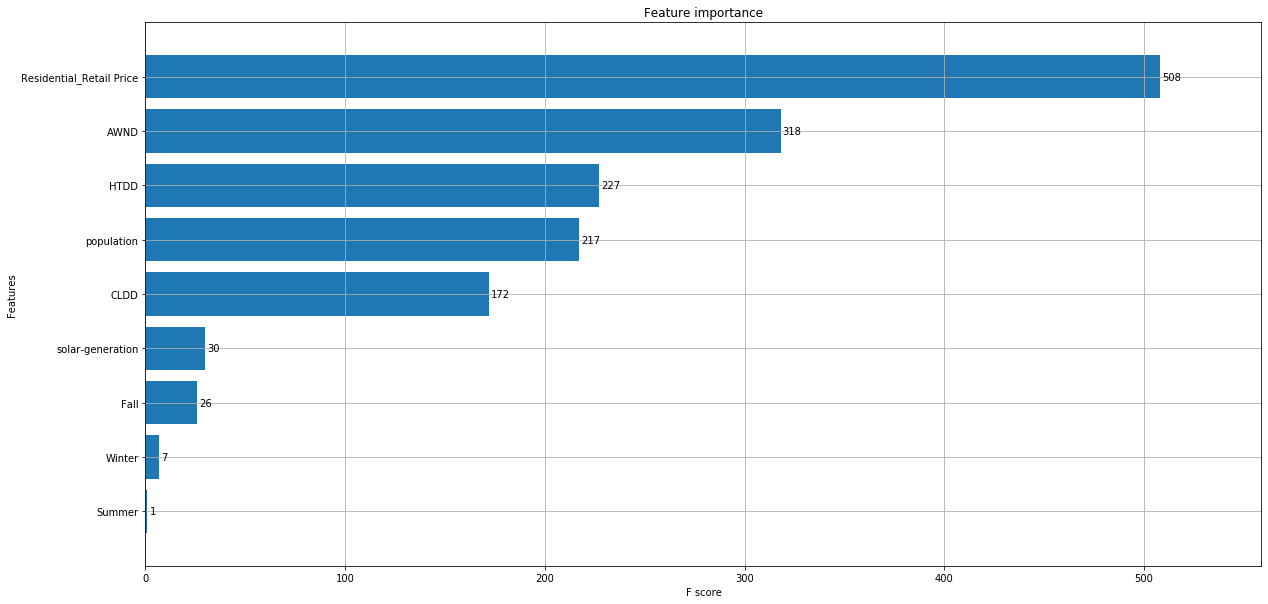

In [41]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


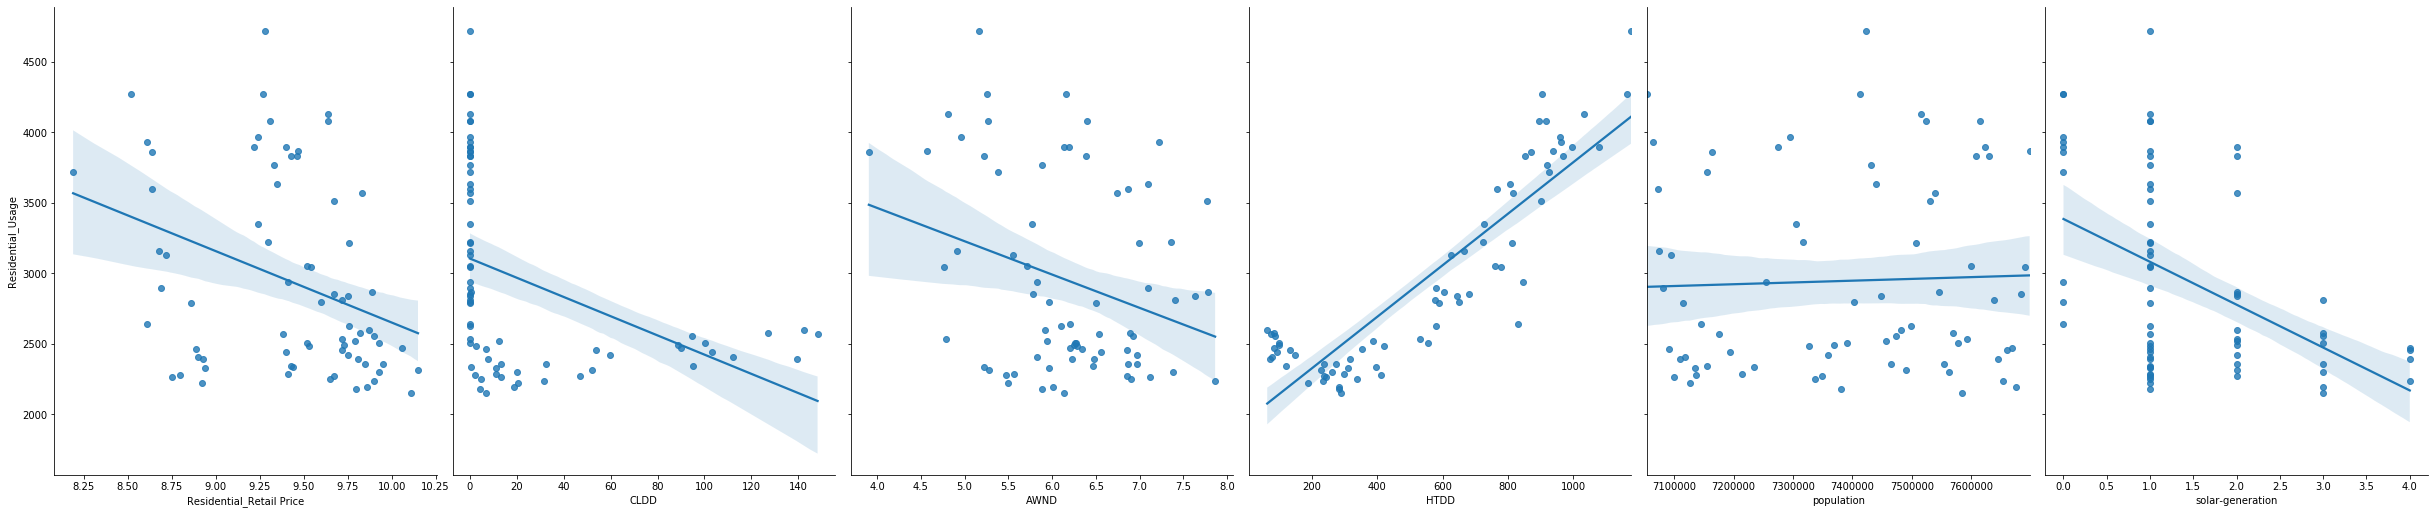

In [42]:
# Correlation Analysis
correlation_analysis(data, residential_numeric_columns_adj, ['Residential_Usage'])

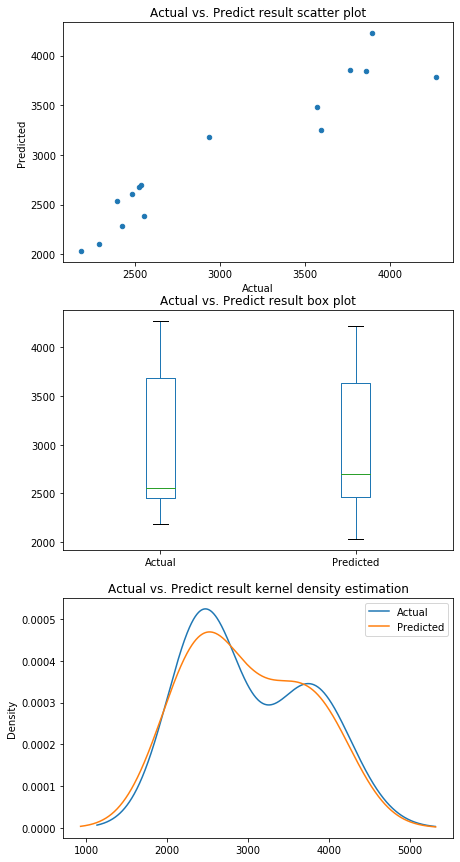

In [43]:
visualize_graph(df_pred_r)

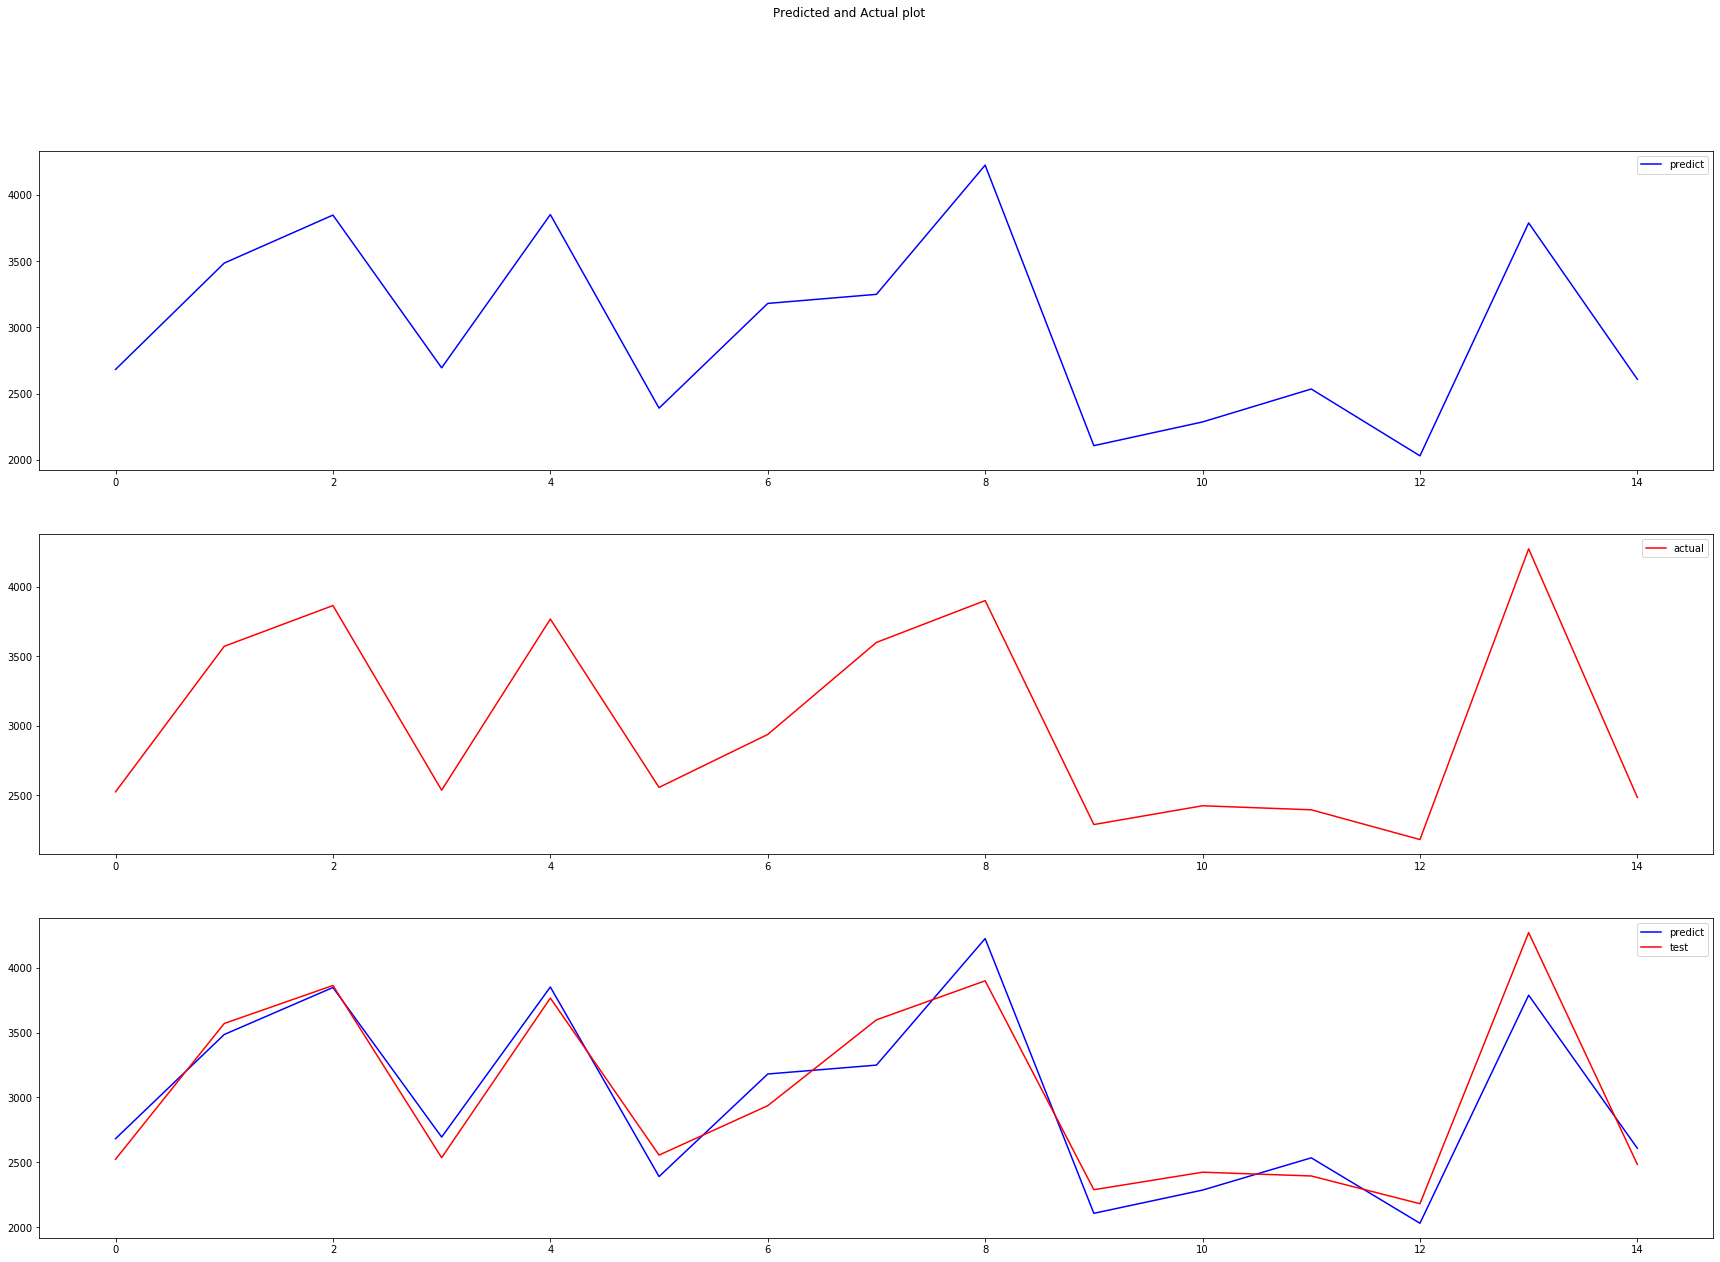

In [44]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)